EDC 

# Importations : 

In [3]:

from PIL import Image, ExifTags
import os
import numpy as np
import pandas as pd
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm
import matplotlib.pyplot as plt


# Data Loading

In [4]:

base_dir = "data" 
test_dir = os.path.join(base_dir, "test_image_headmind")  
dam_dir = os.path.join(base_dir, "DAM") 


def fix_image_orientation(image):
    try:
        
        exif = image._getexif()
        if exif:
            for tag, value in ExifTags.TAGS.items():
                if value == 'Orientation':
                    orientation_tag = tag
                    break
            else:
                orientation_tag = None
            
            # Appliquer la correction basée sur l'orientation
            if orientation_tag and orientation_tag in exif:
                orientation = exif[orientation_tag]
                if orientation == 3:
                    image = image.rotate(180, expand=True)
                elif orientation == 6:
                    image = image.rotate(270, expand=True)
                elif orientation == 8:
                    image = image.rotate(90, expand=True)  
    except Exception as e:
        print(f"Erreur lors de la correction d'orientation : {e}")
    
    return image



def load_and_fix_images(image_dir, fix_rotation=False):

    images = {}
    for image_name in os.listdir(image_dir):
        if image_name.lower().endswith((".jpg", ".jpeg", ".png")):  
            image_path = os.path.join(image_dir, image_name)
            image = Image.open(image_path)
            
            # Corriger l'orientation basée sur EXIF
            image = fix_image_orientation(image)
            if fix_rotation and image.width > image.height:
                image = image.rotate(90, expand=True)
            
            images[image_name] = image
    return images


test_images = load_and_fix_images(test_dir, fix_rotation=True)
dam_images = load_and_fix_images(dam_dir, fix_rotation=False)
output_dir = "test_images_fixed"  
os.makedirs(output_dir, exist_ok=True)

for name, img in test_images.items():
    output_path = os.path.join(output_dir, name)
    img.save(output_path)

print(f"Toutes les images de test ont été corrigées et sauvegardées dans {output_dir}.")


Toutes les images de test ont été corrigées et sauvegardées dans test_images_fixed.


In [5]:
# Vérifier les tailles des images 
def check_image_sizes(images, dataset_name):
    print(f"=== Dimensions des images pour le dataset {dataset_name} ===")
    for name, img in images.items():
        print(f"{name} - Taille : {img.size}")  

check_image_sizes(test_images, "Test")
check_image_sizes(dam_images, "DAM")


=== Dimensions des images pour le dataset Test ===
IMG_6883.jpg - Taille : (1536, 2048)
IMG_6908.jpg - Taille : (1536, 2048)
IMG_6934.jpg - Taille : (1536, 2048)
image-20210928-102721-8eaea48f.jpg - Taille : (3024, 4032)
IMG_6921.jpg - Taille : (1536, 2048)
IMG_6909.jpg - Taille : (1536, 2048)
IMG_6896.jpg - Taille : (1536, 2048)
IMG_6894.jpg - Taille : (1536, 2048)
IMG_6880.jpg - Taille : (1536, 2048)
IMG_6881.jpg - Taille : (1536, 2048)
image-20210928-102718-2474636a.jpg - Taille : (3024, 4032)
image-20210928-102806-79d7094b.jpg - Taille : (3024, 4032)
image-20210928-103157-a46cc321.jpg - Taille : (3024, 4032)
MicrosoftTeams-image_48.png - Taille : (2448, 3264)
IMG_6891.jpg - Taille : (1536, 2048)
IMG_6885.jpg - Taille : (1536, 2048)
IMG_6884.jpg - Taille : (1536, 2048)
IMG_6886.jpg - Taille : (1536, 2048)
IMG_6892.jpg - Taille : (1536, 2048)
IMG_6919.jpg - Taille : (1536, 2048)
image-20210928-102747-05631ad4.jpg - Taille : (3024, 4032)
IMG_6918.jpg - Taille : (1536, 2048)
IMG_6924.j

In [4]:
def resize_images(images, size=(256, 256)):

    resized_images = {}
    for name, img in images.items():
        resized_images[name] = img.resize(size, Image.Resampling.LANCZOS) 
    return resized_images

# Redimensionner les images de test
test_images_resized = resize_images(test_images, size=(256, 256))

output_dir_resized = "test_images_resized"
os.makedirs(output_dir_resized, exist_ok=True)

for name, img in test_images_resized.items():
    output_path = os.path.join(output_dir_resized, name)
    img.save(output_path)

print(f"Toutes les images de test ont été redimensionnées et sauvegardées dans {output_dir_resized}.")


Toutes les images de test ont été redimensionnées et sauvegardées dans test_images_resized.


#  Model Loading : EfficientNet

In [5]:

model = EfficientNetB0(include_top=False, weights="imagenet", pooling="avg")

# Extraction des embeddings

In [7]:
# Extraire les embeddings 
def extract_embeddings(image_data, model):
    embeddings = {}
    for img_name, img_array in tqdm(image_data.items()):
        
        img_batch = np.expand_dims(img_array, axis=0)
        
        embedding = model.predict(img_batch)
        embeddings[img_name] = embedding.flatten()
    return embeddings
dam_embeddings = extract_embeddings(dam_images, model)
test_embeddings = extract_embeddings(test_images_resized, model)

  0%|          | 0/2766 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 855ms/step


  0%|          | 1/2766 [00:00<42:23,  1.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  0%|          | 3/2766 [00:01<13:32,  3.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  0%|          | 5/2766 [00:01<08:14,  5.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  0%|          | 7/2766 [00:01<06:08,  7.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  0%|          | 9/2766 [00:01<04:55,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 11/2766 [00:01<04:29, 10.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 13/2766 [00:01<03:58, 11.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|          | 15/2766 [00:01<03:38, 12.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  1%|          | 17/2766 [00:02<03:24, 13.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  1%|          | 19/2766 [00:02<03:25, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  1%|          | 21/2766 [00:02<03:21, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  1%|          | 23/2766 [00:02<03:16, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 25/2766 [00:02<03:17, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|          | 27/2766 [00:02<03:08, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  1%|          | 29/2766 [00:02<03:05, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 31/2766 [00:02<03:01, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  1%|          | 33/2766 [00:03<02:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 35/2766 [00:03<02:56, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 37/2766 [00:03<02:56, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 39/2766 [00:03<03:04, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  1%|▏         | 41/2766 [00:03<03:00, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 43/2766 [00:03<02:57, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step


  2%|▏         | 45/2766 [00:03<03:34, 12.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 47/2766 [00:04<03:41, 12.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  2%|▏         | 49/2766 [00:04<03:36, 12.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 51/2766 [00:04<03:27, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▏         | 53/2766 [00:04<03:38, 12.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  2%|▏         | 55/2766 [00:04<03:25, 13.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 57/2766 [00:04<03:16, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 59/2766 [00:05<03:12, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 61/2766 [00:05<03:09, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  2%|▏         | 63/2766 [00:05<03:07, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  2%|▏         | 65/2766 [00:05<03:08, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 67/2766 [00:05<03:15, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  2%|▏         | 69/2766 [00:05<03:10, 14.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  3%|▎         | 71/2766 [00:05<03:05, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  3%|▎         | 73/2766 [00:05<03:01, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 75/2766 [00:06<02:58, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  3%|▎         | 77/2766 [00:06<02:57, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 79/2766 [00:06<03:07, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 81/2766 [00:06<03:02, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 83/2766 [00:06<02:59, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  3%|▎         | 85/2766 [00:06<02:58, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  3%|▎         | 87/2766 [00:06<02:56, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 89/2766 [00:07<02:55, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 91/2766 [00:07<02:55, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 93/2766 [00:07<03:03, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  3%|▎         | 95/2766 [00:07<03:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  4%|▎         | 97/2766 [00:07<02:57, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  4%|▎         | 99/2766 [00:07<02:56, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▎         | 101/2766 [00:07<02:58, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▎         | 103/2766 [00:07<02:56, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 105/2766 [00:08<02:54, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  4%|▍         | 107/2766 [00:08<03:06, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 109/2766 [00:08<03:02, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 111/2766 [00:08<02:58, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 113/2766 [00:08<02:56, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 115/2766 [00:08<02:54, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  4%|▍         | 117/2766 [00:08<02:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 119/2766 [00:09<02:53, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 121/2766 [00:09<03:03, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  4%|▍         | 123/2766 [00:09<03:01, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 125/2766 [00:09<02:58, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▍         | 127/2766 [00:09<02:56, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▍         | 129/2766 [00:09<02:55, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▍         | 131/2766 [00:09<02:55, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  5%|▍         | 133/2766 [00:10<03:02, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  5%|▍         | 135/2766 [00:10<03:00, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▍         | 137/2766 [00:10<02:57, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 139/2766 [00:10<02:55, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 141/2766 [00:10<02:52, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 143/2766 [00:10<02:51, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 145/2766 [00:10<02:51, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  5%|▌         | 147/2766 [00:10<03:01, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  5%|▌         | 149/2766 [00:11<02:58, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  5%|▌         | 151/2766 [00:11<02:54, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 153/2766 [00:11<02:51, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 155/2766 [00:11<02:49, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 157/2766 [00:11<02:47, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  6%|▌         | 159/2766 [00:11<02:56, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 161/2766 [00:11<02:53, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 163/2766 [00:12<02:53, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▌         | 165/2766 [00:12<02:51, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 167/2766 [00:12<02:50, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▌         | 169/2766 [00:12<02:48, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▌         | 171/2766 [00:12<02:47, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  6%|▋         | 173/2766 [00:12<02:57, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  6%|▋         | 175/2766 [00:12<02:53, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▋         | 177/2766 [00:12<02:51, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  6%|▋         | 179/2766 [00:13<02:49, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 181/2766 [00:13<02:48, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 183/2766 [00:13<02:46, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 185/2766 [00:13<02:56, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 187/2766 [00:13<02:53, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 189/2766 [00:13<02:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 191/2766 [00:13<02:48, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


  7%|▋         | 193/2766 [00:13<02:49, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 195/2766 [00:14<02:49, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


  7%|▋         | 197/2766 [00:14<02:56, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  7%|▋         | 199/2766 [00:14<02:54, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 201/2766 [00:14<02:50, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  7%|▋         | 203/2766 [00:14<02:48, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  7%|▋         | 205/2766 [00:14<02:47, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  7%|▋         | 207/2766 [00:14<02:45, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 209/2766 [00:15<02:55, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 211/2766 [00:15<02:53, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


  8%|▊         | 213/2766 [00:15<02:51, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 215/2766 [00:15<02:49, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 217/2766 [00:15<02:48, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 219/2766 [00:15<02:48, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 221/2766 [00:15<02:56, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 223/2766 [00:16<02:53, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  8%|▊         | 225/2766 [00:16<02:51, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 227/2766 [00:16<02:50, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  8%|▊         | 229/2766 [00:16<02:49, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  8%|▊         | 231/2766 [00:16<02:46, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


  8%|▊         | 233/2766 [00:16<02:57, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  8%|▊         | 235/2766 [00:16<02:56, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▊         | 237/2766 [00:16<02:52, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▊         | 239/2766 [00:17<02:50, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


  9%|▊         | 241/2766 [00:17<02:50, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 243/2766 [00:17<02:49, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  9%|▉         | 245/2766 [00:17<02:56, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 247/2766 [00:17<02:53, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 249/2766 [00:17<02:50, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 251/2766 [00:17<02:48, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 253/2766 [00:18<02:46, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


  9%|▉         | 255/2766 [00:18<02:44, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 257/2766 [00:18<02:53, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


  9%|▉         | 259/2766 [00:18<02:52, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


  9%|▉         | 261/2766 [00:18<02:49, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|▉         | 263/2766 [00:18<02:48, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 265/2766 [00:18<02:46, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|▉         | 267/2766 [00:18<02:44, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|▉         | 269/2766 [00:19<02:54, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|▉         | 271/2766 [00:19<02:51, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 273/2766 [00:19<02:48, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 10%|▉         | 275/2766 [00:19<02:46, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|█         | 277/2766 [00:19<02:45, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|█         | 279/2766 [00:19<02:44, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 10%|█         | 281/2766 [00:19<02:55, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 283/2766 [00:20<02:51, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 10%|█         | 285/2766 [00:20<02:49, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 10%|█         | 287/2766 [00:20<02:46, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 10%|█         | 289/2766 [00:20<02:47, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 291/2766 [00:20<02:45, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 293/2766 [00:20<02:54, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 295/2766 [00:20<02:50, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 297/2766 [00:21<02:46, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 299/2766 [00:21<02:44, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 301/2766 [00:21<02:44, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 303/2766 [00:21<02:42, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 11%|█         | 305/2766 [00:21<02:54, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 11%|█         | 307/2766 [00:21<02:50, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 11%|█         | 309/2766 [00:21<02:46, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█         | 311/2766 [00:21<02:44, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█▏        | 313/2766 [00:22<02:42, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 11%|█▏        | 315/2766 [00:22<02:49, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 11%|█▏        | 317/2766 [00:22<02:46, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 319/2766 [00:22<02:45, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 12%|█▏        | 321/2766 [00:22<02:44, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 12%|█▏        | 323/2766 [00:22<02:43, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 12%|█▏        | 325/2766 [00:22<02:42, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 327/2766 [00:23<02:48, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 329/2766 [00:23<02:45, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 331/2766 [00:23<02:43, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 12%|█▏        | 333/2766 [00:23<02:40, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 335/2766 [00:23<02:39, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 12%|█▏        | 337/2766 [00:23<02:46, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 12%|█▏        | 339/2766 [00:23<02:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 341/2766 [00:23<02:44, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 12%|█▏        | 343/2766 [00:24<02:42, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 12%|█▏        | 345/2766 [00:24<02:43, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 347/2766 [00:24<02:42, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 349/2766 [00:24<02:50, 14.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 351/2766 [00:24<02:46, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 353/2766 [00:24<02:46, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 355/2766 [00:24<02:43, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 357/2766 [00:25<02:41, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 359/2766 [00:25<02:48, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 13%|█▎        | 361/2766 [00:25<02:48, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 363/2766 [00:25<02:45, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 365/2766 [00:25<02:44, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 13%|█▎        | 367/2766 [00:25<02:44, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 369/2766 [00:25<02:42, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 13%|█▎        | 371/2766 [00:26<02:50, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 13%|█▎        | 373/2766 [00:26<02:45, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▎        | 375/2766 [00:26<02:45, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▎        | 377/2766 [00:26<02:43, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 14%|█▎        | 379/2766 [00:26<02:49, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 14%|█▍        | 381/2766 [00:26<02:56, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 14%|█▍        | 383/2766 [00:26<02:51, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 14%|█▍        | 385/2766 [00:27<02:46, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 118ms/step


 14%|█▍        | 387/2766 [00:27<03:26, 11.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 14%|█▍        | 389/2766 [00:27<03:28, 11.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 14%|█▍        | 391/2766 [00:28<05:43,  6.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 14%|█▍        | 393/2766 [00:28<05:04,  7.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 14%|█▍        | 394/2766 [00:28<04:58,  7.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 14%|█▍        | 395/2766 [00:28<04:53,  8.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 14%|█▍        | 396/2766 [00:28<04:50,  8.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step


 14%|█▍        | 397/2766 [00:28<05:18,  7.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 399/2766 [00:28<04:32,  8.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 14%|█▍        | 401/2766 [00:29<03:52, 10.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 403/2766 [00:29<03:33, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█▍        | 405/2766 [00:29<03:14, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█▍        | 407/2766 [00:29<03:01, 12.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 409/2766 [00:29<03:33, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 15%|█▍        | 411/2766 [00:29<03:30, 11.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▍        | 413/2766 [00:30<03:17, 11.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 15%|█▌        | 415/2766 [00:30<03:05, 12.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 15%|█▌        | 417/2766 [00:30<02:59, 13.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▌        | 419/2766 [00:30<02:55, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 421/2766 [00:30<02:58, 13.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 15%|█▌        | 423/2766 [00:30<02:54, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▌        | 425/2766 [00:30<02:49, 13.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 15%|█▌        | 427/2766 [00:31<02:46, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 429/2766 [00:31<02:44, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 431/2766 [00:31<02:42, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 16%|█▌        | 433/2766 [00:31<02:48, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 16%|█▌        | 435/2766 [00:31<02:44, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|█▌        | 437/2766 [00:31<02:41, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 439/2766 [00:31<02:39, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 441/2766 [00:31<02:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▌        | 443/2766 [00:32<02:45, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 16%|█▌        | 445/2766 [00:32<02:42, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 447/2766 [00:32<02:41, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 16%|█▌        | 449/2766 [00:32<02:38, 14.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▋        | 451/2766 [00:32<02:37, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 16%|█▋        | 453/2766 [00:32<02:44, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 16%|█▋        | 455/2766 [00:32<02:40, 14.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 457/2766 [00:33<02:37, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 459/2766 [00:33<02:34, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 17%|█▋        | 461/2766 [00:33<02:37, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 463/2766 [00:33<02:44, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 17%|█▋        | 465/2766 [00:33<02:43, 14.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 17%|█▋        | 467/2766 [00:33<02:42, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 469/2766 [00:33<02:40, 14.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 471/2766 [00:34<02:38, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 17%|█▋        | 473/2766 [00:34<02:50, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 17%|█▋        | 475/2766 [00:34<02:47, 13.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 17%|█▋        | 477/2766 [00:34<03:25, 11.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 17%|█▋        | 479/2766 [00:34<03:21, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 17%|█▋        | 481/2766 [00:34<03:09, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 17%|█▋        | 483/2766 [00:35<03:17, 11.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 485/2766 [00:35<03:08, 12.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 18%|█▊        | 487/2766 [00:35<02:59, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 489/2766 [00:35<02:49, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 491/2766 [00:35<02:43, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 493/2766 [00:35<02:50, 13.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 18%|█▊        | 495/2766 [00:35<02:49, 13.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 18%|█▊        | 497/2766 [00:36<02:41, 14.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 499/2766 [00:36<02:35, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 18%|█▊        | 501/2766 [00:36<02:32, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 503/2766 [00:36<02:32, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 505/2766 [00:36<02:27, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 18%|█▊        | 507/2766 [00:36<02:36, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 18%|█▊        | 509/2766 [00:36<02:31, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 511/2766 [00:37<02:28, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▊        | 513/2766 [00:37<02:25, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 19%|█▊        | 515/2766 [00:37<02:24, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▊        | 517/2766 [00:37<02:23, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 519/2766 [00:37<02:22, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 521/2766 [00:37<02:29, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 523/2766 [00:37<02:30, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 525/2766 [00:37<02:26, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 527/2766 [00:38<02:23, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 529/2766 [00:38<02:22, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 19%|█▉        | 531/2766 [00:38<02:19, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 533/2766 [00:38<02:27, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 535/2766 [00:38<02:27, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 537/2766 [00:38<02:23, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 19%|█▉        | 539/2766 [00:38<02:21, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 541/2766 [00:38<02:19, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 543/2766 [00:39<02:19, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 545/2766 [00:39<02:18, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|█▉        | 547/2766 [00:39<02:26, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 549/2766 [00:39<02:23, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 551/2766 [00:39<02:21, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|█▉        | 553/2766 [00:39<02:20, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 555/2766 [00:39<02:18, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 557/2766 [00:39<02:17, 16.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 559/2766 [00:40<02:16, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 561/2766 [00:40<02:24, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 20%|██        | 563/2766 [00:40<02:21, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 565/2766 [00:40<02:20, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 20%|██        | 567/2766 [00:40<02:18, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██        | 569/2766 [00:40<02:18, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 21%|██        | 571/2766 [00:40<02:34, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 21%|██        | 573/2766 [00:41<02:55, 12.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██        | 575/2766 [00:41<02:45, 13.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 577/2766 [00:41<02:35, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██        | 579/2766 [00:41<02:30, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 581/2766 [00:41<02:25, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 21%|██        | 583/2766 [00:41<02:22, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 21%|██        | 585/2766 [00:41<02:28, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██        | 587/2766 [00:42<02:23, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 21%|██▏       | 589/2766 [00:42<02:20, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 21%|██▏       | 591/2766 [00:42<02:18, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 21%|██▏       | 593/2766 [00:42<02:16, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 595/2766 [00:42<02:15, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 22%|██▏       | 597/2766 [00:42<02:21, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 599/2766 [00:42<02:18, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 601/2766 [00:42<02:17, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 603/2766 [00:43<02:15, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 22%|██▏       | 605/2766 [00:43<02:16, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 22%|██▏       | 607/2766 [00:43<02:17, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 609/2766 [00:43<02:22, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 611/2766 [00:43<02:19, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 613/2766 [00:43<02:16, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 22%|██▏       | 615/2766 [00:43<02:14, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 22%|██▏       | 617/2766 [00:43<02:14, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 22%|██▏       | 619/2766 [00:44<02:15, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 22%|██▏       | 621/2766 [00:44<02:14, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 623/2766 [00:44<02:21, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 23%|██▎       | 625/2766 [00:44<02:19, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 627/2766 [00:44<02:17, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 629/2766 [00:44<02:15, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 631/2766 [00:44<02:14, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 633/2766 [00:44<02:13, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 635/2766 [00:45<02:21, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 637/2766 [00:45<02:17, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 639/2766 [00:45<02:14, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 23%|██▎       | 641/2766 [00:45<02:12, 15.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 643/2766 [00:45<02:13, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 23%|██▎       | 645/2766 [00:45<02:11, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 647/2766 [00:45<02:19, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 23%|██▎       | 649/2766 [00:45<02:17, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▎       | 651/2766 [00:46<02:15, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▎       | 653/2766 [00:46<02:12, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▎       | 655/2766 [00:46<02:11, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step


 24%|██▍       | 657/2766 [00:46<02:22, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 659/2766 [00:46<02:19, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 661/2766 [00:46<02:15, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 24%|██▍       | 663/2766 [00:46<02:14, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 665/2766 [00:46<02:12, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 667/2766 [00:47<02:12, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 669/2766 [00:47<02:18, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 671/2766 [00:47<02:15, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 24%|██▍       | 673/2766 [00:47<02:14, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 24%|██▍       | 675/2766 [00:47<02:21, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 24%|██▍       | 677/2766 [00:47<02:16, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 679/2766 [00:47<02:15, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 25%|██▍       | 681/2766 [00:48<02:21, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▍       | 683/2766 [00:48<02:16, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 685/2766 [00:48<02:14, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▍       | 687/2766 [00:48<02:11, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 689/2766 [00:48<02:09, 16.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▍       | 691/2766 [00:48<02:08, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 693/2766 [00:48<02:15, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 695/2766 [00:48<02:12, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 697/2766 [00:49<02:11, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 25%|██▌       | 699/2766 [00:49<02:09, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 701/2766 [00:49<02:08, 16.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 25%|██▌       | 703/2766 [00:49<02:08, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 25%|██▌       | 705/2766 [00:49<02:08, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 707/2766 [00:49<02:15, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 26%|██▌       | 709/2766 [00:49<02:13, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 711/2766 [00:49<02:10, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 713/2766 [00:50<02:09, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▌       | 715/2766 [00:50<02:09, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 717/2766 [00:50<02:08, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 719/2766 [00:50<02:14, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 721/2766 [00:50<02:12, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▌       | 723/2766 [00:50<02:09, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 26%|██▌       | 725/2766 [00:50<02:08, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 26%|██▋       | 727/2766 [00:50<02:08, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▋       | 729/2766 [00:51<02:07, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 26%|██▋       | 731/2766 [00:51<02:14, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 733/2766 [00:51<02:12, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 735/2766 [00:51<02:09, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 737/2766 [00:51<02:07, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 739/2766 [00:51<02:07, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 741/2766 [00:51<02:07, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 27%|██▋       | 743/2766 [00:52<02:16, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 745/2766 [00:52<02:13, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 27%|██▋       | 747/2766 [00:52<02:10, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 27%|██▋       | 749/2766 [00:52<02:08, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 751/2766 [00:52<02:09, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 753/2766 [00:52<02:08, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 27%|██▋       | 755/2766 [00:52<02:16, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 757/2766 [00:52<02:13, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 27%|██▋       | 759/2766 [00:53<02:10, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 761/2766 [00:53<02:08, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 763/2766 [00:53<02:07, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 765/2766 [00:53<02:08, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 767/2766 [00:53<02:13, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 769/2766 [00:53<02:10, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 28%|██▊       | 771/2766 [00:53<02:09, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 773/2766 [00:53<02:07, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 28%|██▊       | 775/2766 [00:54<02:07, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 777/2766 [00:54<02:06, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 779/2766 [00:54<02:12, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 28%|██▊       | 781/2766 [00:54<02:09, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 783/2766 [00:54<02:07, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 28%|██▊       | 785/2766 [00:54<02:04, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 787/2766 [00:54<02:04, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 789/2766 [00:54<02:10, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 791/2766 [00:55<02:07, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▊       | 793/2766 [00:55<02:05, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 29%|██▊       | 795/2766 [00:55<02:03, 15.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 797/2766 [00:55<02:02, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 799/2766 [00:55<02:08, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 801/2766 [00:55<02:06, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 803/2766 [00:55<02:04, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 805/2766 [00:55<02:03, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 807/2766 [00:56<02:02, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 809/2766 [00:56<02:08, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 29%|██▉       | 811/2766 [00:56<02:05, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 813/2766 [00:56<02:03, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 29%|██▉       | 815/2766 [00:56<02:02, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 817/2766 [00:56<02:02, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 30%|██▉       | 819/2766 [00:56<02:09, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|██▉       | 821/2766 [00:57<02:05, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|██▉       | 823/2766 [00:57<02:03, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 825/2766 [00:57<02:02, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 827/2766 [00:57<02:01, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|██▉       | 829/2766 [00:57<02:00, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 831/2766 [00:57<02:06, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 30%|███       | 833/2766 [00:57<02:03, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 835/2766 [00:57<02:02, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 837/2766 [00:58<02:01, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 839/2766 [00:58<02:02, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 30%|███       | 841/2766 [00:58<02:08, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 843/2766 [00:58<02:04, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 31%|███       | 845/2766 [00:58<02:02, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 847/2766 [00:58<02:01, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


 31%|███       | 849/2766 [00:58<02:30, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 31%|███       | 851/2766 [00:59<02:32, 12.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 31%|███       | 853/2766 [00:59<02:23, 13.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 855/2766 [00:59<02:16, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 857/2766 [00:59<02:10, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███       | 859/2766 [00:59<02:08, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 31%|███       | 861/2766 [00:59<02:11, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███       | 863/2766 [00:59<02:07, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███▏      | 865/2766 [00:59<02:03, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███▏      | 867/2766 [01:00<02:01, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 31%|███▏      | 869/2766 [01:00<02:00, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 31%|███▏      | 871/2766 [01:00<01:59, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 873/2766 [01:00<02:06, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 875/2766 [01:00<02:03, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 877/2766 [01:00<02:00, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 879/2766 [01:00<02:00, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 881/2766 [01:00<01:58, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 32%|███▏      | 883/2766 [01:01<02:04, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 885/2766 [01:01<02:01, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 887/2766 [01:01<01:59, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 889/2766 [01:01<01:59, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 32%|███▏      | 891/2766 [01:01<01:56, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 893/2766 [01:01<02:02, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 895/2766 [01:01<02:01, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▏      | 897/2766 [01:02<02:00, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 33%|███▎      | 899/2766 [01:02<02:02, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 901/2766 [01:02<01:59, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 33%|███▎      | 903/2766 [01:02<02:04, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 905/2766 [01:02<02:01, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 907/2766 [01:02<01:59, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 909/2766 [01:02<01:58, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 911/2766 [01:02<01:57, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 33%|███▎      | 913/2766 [01:03<02:03, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 33%|███▎      | 915/2766 [01:03<02:00, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 917/2766 [01:03<01:57, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 33%|███▎      | 919/2766 [01:03<01:56, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 921/2766 [01:03<01:55, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 33%|███▎      | 923/2766 [01:03<02:01, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 33%|███▎      | 925/2766 [01:03<01:58, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▎      | 927/2766 [01:03<01:57, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▎      | 929/2766 [01:04<01:55, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▎      | 931/2766 [01:04<01:55, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 34%|███▎      | 933/2766 [01:04<02:01, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 935/2766 [01:04<02:00, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 34%|███▍      | 937/2766 [01:04<01:59, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 939/2766 [01:04<01:56, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 941/2766 [01:04<01:54, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 943/2766 [01:05<02:02, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 945/2766 [01:05<01:59, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 34%|███▍      | 947/2766 [01:05<01:56, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 949/2766 [01:05<01:55, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 34%|███▍      | 951/2766 [01:05<01:54, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 34%|███▍      | 953/2766 [01:05<01:59, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 955/2766 [01:05<01:57, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▍      | 957/2766 [01:05<01:57, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▍      | 959/2766 [01:06<01:55, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 35%|███▍      | 961/2766 [01:06<01:54, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 963/2766 [01:06<02:00, 14.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 965/2766 [01:06<01:57, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▍      | 967/2766 [01:06<01:56, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 35%|███▌      | 969/2766 [01:06<01:56, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 35%|███▌      | 971/2766 [01:06<01:55, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 973/2766 [01:06<02:00, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 975/2766 [01:07<01:58, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 977/2766 [01:07<01:55, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 35%|███▌      | 979/2766 [01:07<01:56, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 35%|███▌      | 981/2766 [01:07<01:56, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▌      | 983/2766 [01:07<02:01, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 985/2766 [01:07<01:59, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 987/2766 [01:07<01:56, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 989/2766 [01:07<01:55, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 991/2766 [01:08<01:55, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 993/2766 [01:08<01:53, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 995/2766 [01:08<01:58, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 36%|███▌      | 997/2766 [01:08<01:56, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▌      | 999/2766 [01:08<01:54, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▌      | 1001/2766 [01:08<01:52, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 36%|███▋      | 1003/2766 [01:08<01:52, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 36%|███▋      | 1005/2766 [01:09<01:59, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 1007/2766 [01:09<01:56, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 36%|███▋      | 1009/2766 [01:09<01:54, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1011/2766 [01:09<01:52, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 37%|███▋      | 1013/2766 [01:09<01:51, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1015/2766 [01:09<01:58, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1017/2766 [01:09<01:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1019/2766 [01:09<01:53, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1021/2766 [01:10<01:51, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1023/2766 [01:10<01:49, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1025/2766 [01:10<01:56, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1027/2766 [01:10<01:54, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1029/2766 [01:10<01:52, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1031/2766 [01:10<01:50, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 37%|███▋      | 1033/2766 [01:10<01:49, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 37%|███▋      | 1035/2766 [01:10<01:54, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 37%|███▋      | 1037/2766 [01:11<01:51, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 1039/2766 [01:11<01:50, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1041/2766 [01:11<01:48, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1043/2766 [01:11<01:48, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 1045/2766 [01:11<01:53, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1047/2766 [01:11<01:51, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1049/2766 [01:11<01:49, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1051/2766 [01:12<01:48, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1053/2766 [01:12<01:47, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1055/2766 [01:12<01:54, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 38%|███▊      | 1057/2766 [01:12<01:52, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 38%|███▊      | 1059/2766 [01:12<01:50, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 1061/2766 [01:12<01:48, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 38%|███▊      | 1063/2766 [01:12<01:48, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 39%|███▊      | 1065/2766 [01:12<01:53, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 1067/2766 [01:13<01:51, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▊      | 1069/2766 [01:13<01:49, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▊      | 1071/2766 [01:13<01:47, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1073/2766 [01:13<01:46, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1075/2766 [01:13<01:52, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1077/2766 [01:13<01:49, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 39%|███▉      | 1079/2766 [01:13<02:02, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 39%|███▉      | 1081/2766 [01:14<02:07, 13.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1083/2766 [01:14<02:01, 13.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 39%|███▉      | 1085/2766 [01:14<02:04, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1087/2766 [01:14<01:58, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 39%|███▉      | 1089/2766 [01:14<01:52, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 39%|███▉      | 1091/2766 [01:14<01:50, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 40%|███▉      | 1093/2766 [01:14<01:49, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 1095/2766 [01:14<01:53, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 1097/2766 [01:15<01:50, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|███▉      | 1099/2766 [01:15<01:48, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 1101/2766 [01:15<01:46, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|███▉      | 1103/2766 [01:15<01:44, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 40%|███▉      | 1105/2766 [01:15<01:48, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 40%|████      | 1107/2766 [01:15<01:46, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1109/2766 [01:15<01:45, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1111/2766 [01:15<01:44, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 40%|████      | 1113/2766 [01:16<01:44, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1115/2766 [01:16<01:49, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1117/2766 [01:16<01:46, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 1119/2766 [01:16<01:45, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1121/2766 [01:16<01:43, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1123/2766 [01:16<01:43, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1125/2766 [01:16<01:49, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1127/2766 [01:17<01:46, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1129/2766 [01:17<01:44, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████      | 1131/2766 [01:17<01:43, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1133/2766 [01:17<01:56, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████      | 1135/2766 [01:17<01:52, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 41%|████      | 1137/2766 [01:17<01:49, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████      | 1139/2766 [01:17<01:48, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 41%|████▏     | 1141/2766 [01:17<01:49, 14.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 41%|████▏     | 1143/2766 [01:18<01:53, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 41%|████▏     | 1145/2766 [01:18<01:49, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 41%|████▏     | 1147/2766 [01:18<01:46, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 42%|████▏     | 1149/2766 [01:18<01:43, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1151/2766 [01:18<01:49, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 1153/2766 [01:18<01:47, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1155/2766 [01:18<01:44, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 42%|████▏     | 1157/2766 [01:19<01:42, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 42%|████▏     | 1159/2766 [01:19<01:43, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 42%|████▏     | 1161/2766 [01:19<01:49, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1163/2766 [01:19<01:46, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1165/2766 [01:19<01:43, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1167/2766 [01:19<01:42, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 42%|████▏     | 1169/2766 [01:19<01:41, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1171/2766 [01:19<01:47, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▏     | 1173/2766 [01:20<01:44, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 42%|████▏     | 1175/2766 [01:20<01:42, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1177/2766 [01:20<01:40, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1179/2766 [01:20<01:39, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 43%|████▎     | 1181/2766 [01:20<01:44, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1183/2766 [01:20<01:42, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1185/2766 [01:20<01:40, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1187/2766 [01:20<01:39, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 43%|████▎     | 1189/2766 [01:21<01:38, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1191/2766 [01:21<01:42, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1193/2766 [01:21<01:40, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 43%|████▎     | 1195/2766 [01:21<01:39, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1197/2766 [01:21<01:37, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 43%|████▎     | 1199/2766 [01:21<01:42, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 43%|████▎     | 1201/2766 [01:21<01:39, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 43%|████▎     | 1203/2766 [01:21<01:37, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▎     | 1205/2766 [01:22<01:35, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▎     | 1207/2766 [01:22<01:35, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 44%|████▎     | 1209/2766 [01:22<01:40, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1211/2766 [01:22<01:37, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1213/2766 [01:22<01:36, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1215/2766 [01:22<01:35, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1217/2766 [01:22<01:33, 16.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 44%|████▍     | 1219/2766 [01:22<01:39, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1221/2766 [01:23<01:37, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1223/2766 [01:23<01:35, 16.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 44%|████▍     | 1225/2766 [01:23<01:33, 16.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 44%|████▍     | 1227/2766 [01:23<01:33, 16.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 44%|████▍     | 1229/2766 [01:23<01:38, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1231/2766 [01:23<01:36, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1233/2766 [01:23<01:34, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1235/2766 [01:23<01:33, 16.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1237/2766 [01:24<01:38, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▍     | 1239/2766 [01:24<01:36, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 45%|████▍     | 1241/2766 [01:24<01:34, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▍     | 1243/2766 [01:24<01:33, 16.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 45%|████▌     | 1245/2766 [01:24<01:38, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 1247/2766 [01:24<01:36, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 45%|████▌     | 1249/2766 [01:24<01:34, 16.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1251/2766 [01:24<01:33, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1253/2766 [01:25<01:32, 16.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 45%|████▌     | 1255/2766 [01:25<01:39, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 45%|████▌     | 1257/2766 [01:25<01:37, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1259/2766 [01:25<01:35, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1261/2766 [01:25<01:33, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1263/2766 [01:25<01:38, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1265/2766 [01:25<01:36, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1267/2766 [01:25<01:35, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 46%|████▌     | 1269/2766 [01:26<01:33, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1271/2766 [01:26<01:39, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▌     | 1273/2766 [01:26<01:36, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 46%|████▌     | 1275/2766 [01:26<01:33, 15.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1277/2766 [01:26<01:32, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▌     | 1279/2766 [01:26<01:38, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▋     | 1281/2766 [01:26<01:35, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 46%|████▋     | 1283/2766 [01:27<01:34, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 46%|████▋     | 1285/2766 [01:27<01:33, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1287/2766 [01:27<01:37, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1289/2766 [01:27<01:34, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1291/2766 [01:27<01:33, 15.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1293/2766 [01:27<01:32, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1295/2766 [01:27<01:36, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1297/2766 [01:27<01:34, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1299/2766 [01:28<01:34, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 47%|████▋     | 1301/2766 [01:28<01:32, 15.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1303/2766 [01:28<01:30, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 47%|████▋     | 1305/2766 [01:28<01:35, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 47%|████▋     | 1307/2766 [01:28<01:32, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1309/2766 [01:28<01:30, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1311/2766 [01:28<01:29, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 47%|████▋     | 1313/2766 [01:28<01:34, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1315/2766 [01:29<01:31, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1317/2766 [01:29<01:30, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1319/2766 [01:29<01:29, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 48%|████▊     | 1321/2766 [01:29<01:33, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1323/2766 [01:29<01:31, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1325/2766 [01:29<01:29, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1327/2766 [01:29<01:29, 16.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1329/2766 [01:29<01:28, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 1331/2766 [01:30<01:34, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1333/2766 [01:30<01:32, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 48%|████▊     | 1335/2766 [01:30<01:30, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1337/2766 [01:30<01:28, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 48%|████▊     | 1339/2766 [01:30<01:32, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 48%|████▊     | 1341/2766 [01:30<01:30, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 1343/2766 [01:30<01:29, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▊     | 1345/2766 [01:30<01:27, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▊     | 1347/2766 [01:31<01:26, 16.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1349/2766 [01:31<01:31, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1351/2766 [01:31<01:29, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1353/2766 [01:31<01:27, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1355/2766 [01:31<01:27, 16.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1357/2766 [01:31<01:31, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1359/2766 [01:31<01:29, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 49%|████▉     | 1361/2766 [01:31<01:27, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1363/2766 [01:32<01:26, 16.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 49%|████▉     | 1365/2766 [01:32<01:31, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 49%|████▉     | 1367/2766 [01:32<01:28, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 49%|████▉     | 1369/2766 [01:32<01:27, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|████▉     | 1371/2766 [01:32<01:26, 16.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 50%|████▉     | 1373/2766 [01:32<01:30, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 1375/2766 [01:32<01:29, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 1377/2766 [01:32<01:27, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|████▉     | 1379/2766 [01:33<01:26, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 50%|████▉     | 1381/2766 [01:33<01:31, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 50%|█████     | 1383/2766 [01:33<01:29, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 1385/2766 [01:33<01:27, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 1387/2766 [01:33<01:26, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 50%|█████     | 1389/2766 [01:33<01:32, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 50%|█████     | 1391/2766 [01:33<01:29, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 50%|█████     | 1393/2766 [01:34<01:27, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 50%|█████     | 1395/2766 [01:34<01:27, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 1397/2766 [01:34<01:26, 15.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1399/2766 [01:34<01:31, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 1401/2766 [01:34<01:29, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 51%|█████     | 1403/2766 [01:34<01:28, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1405/2766 [01:34<01:27, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 51%|█████     | 1407/2766 [01:34<01:34, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 51%|█████     | 1409/2766 [01:35<01:32, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1411/2766 [01:35<01:31, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1413/2766 [01:35<01:28, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 51%|█████     | 1415/2766 [01:35<01:32, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████     | 1417/2766 [01:35<01:29, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 1419/2766 [01:35<01:27, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 51%|█████▏    | 1421/2766 [01:35<01:25, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 51%|█████▏    | 1423/2766 [01:36<01:30, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1425/2766 [01:36<01:27, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1427/2766 [01:36<01:25, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1429/2766 [01:36<01:25, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 1431/2766 [01:36<01:28, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1433/2766 [01:36<01:26, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1435/2766 [01:36<01:25, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1437/2766 [01:36<01:24, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 1439/2766 [01:37<01:28, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 52%|█████▏    | 1441/2766 [01:37<01:26, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1443/2766 [01:37<01:24, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1445/2766 [01:37<01:23, 15.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 52%|█████▏    | 1447/2766 [01:37<01:27, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▏    | 1449/2766 [01:37<01:25, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 52%|█████▏    | 1451/2766 [01:37<01:24, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1453/2766 [01:37<01:23, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 53%|█████▎    | 1455/2766 [01:38<01:28, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1457/2766 [01:38<01:25, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1459/2766 [01:38<01:24, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1461/2766 [01:38<01:23, 15.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 53%|█████▎    | 1463/2766 [01:38<01:27, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1465/2766 [01:38<01:25, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1467/2766 [01:38<01:23, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1469/2766 [01:38<01:22, 15.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1471/2766 [01:39<01:27, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 53%|█████▎    | 1473/2766 [01:39<01:25, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 53%|█████▎    | 1475/2766 [01:39<01:24, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1477/2766 [01:39<01:23, 15.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 53%|█████▎    | 1479/2766 [01:39<01:21, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 1481/2766 [01:39<01:26, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▎    | 1483/2766 [01:39<01:25, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▎    | 1485/2766 [01:40<01:23, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 54%|█████▍    | 1487/2766 [01:40<01:21, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1489/2766 [01:40<01:27, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 1491/2766 [01:40<01:24, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1493/2766 [01:40<01:22, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1495/2766 [01:40<01:22, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1497/2766 [01:40<01:22, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 54%|█████▍    | 1499/2766 [01:40<01:26, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 1501/2766 [01:41<01:24, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 1503/2766 [01:41<01:22, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 54%|█████▍    | 1505/2766 [01:41<01:20, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 54%|█████▍    | 1507/2766 [01:41<01:25, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 1509/2766 [01:41<01:22, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 1511/2766 [01:41<01:20, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 1513/2766 [01:41<01:19, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 1515/2766 [01:42<01:22, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 1517/2766 [01:42<01:20, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 55%|█████▍    | 1519/2766 [01:42<01:19, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▍    | 1521/2766 [01:42<01:18, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 1523/2766 [01:42<01:21, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 55%|█████▌    | 1525/2766 [01:42<01:18, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 1527/2766 [01:42<01:17, 16.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 1529/2766 [01:42<01:15, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 55%|█████▌    | 1531/2766 [01:43<01:20, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 1533/2766 [01:43<01:18, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 55%|█████▌    | 1535/2766 [01:43<01:16, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 1537/2766 [01:43<01:16, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1539/2766 [01:43<01:19, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1541/2766 [01:43<01:16, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1543/2766 [01:43<01:16, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▌    | 1545/2766 [01:43<01:15, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1547/2766 [01:44<01:19, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1549/2766 [01:44<01:17, 15.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 56%|█████▌    | 1551/2766 [01:44<01:15, 16.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▌    | 1553/2766 [01:44<01:14, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 56%|█████▌    | 1555/2766 [01:44<01:19, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 1557/2766 [01:44<01:17, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 56%|█████▋    | 1559/2766 [01:44<01:16, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 56%|█████▋    | 1561/2766 [01:44<01:15, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 57%|█████▋    | 1563/2766 [01:45<01:19, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1565/2766 [01:45<01:17, 15.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1567/2766 [01:45<01:16, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1569/2766 [01:45<01:16, 15.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 1571/2766 [01:45<01:19, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 1573/2766 [01:45<01:17, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 1575/2766 [01:45<01:15, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 57%|█████▋    | 1577/2766 [01:45<01:19, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 57%|█████▋    | 1579/2766 [01:46<01:17, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▋    | 1581/2766 [01:46<01:16, 15.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 1583/2766 [01:46<01:15, 15.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 57%|█████▋    | 1585/2766 [01:46<01:18, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1587/2766 [01:46<01:16, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 57%|█████▋    | 1589/2766 [01:46<01:14, 15.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1591/2766 [01:46<01:14, 15.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1593/2766 [01:46<01:18, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1595/2766 [01:47<01:16, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1597/2766 [01:47<01:14, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 58%|█████▊    | 1599/2766 [01:47<01:13, 15.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1601/2766 [01:47<01:17, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1603/2766 [01:47<01:15, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step


 58%|█████▊    | 1605/2766 [01:47<01:25, 13.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1607/2766 [01:47<01:30, 12.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1609/2766 [01:48<01:25, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 1611/2766 [01:48<01:20, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 58%|█████▊    | 1613/2766 [01:48<01:17, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 58%|█████▊    | 1615/2766 [01:48<01:19, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 58%|█████▊    | 1617/2766 [01:48<01:15, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 1619/2766 [01:48<01:13, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step


 59%|█████▊    | 1621/2766 [01:48<01:23, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▊    | 1623/2766 [01:49<01:20, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▊    | 1625/2766 [01:49<01:17, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 1627/2766 [01:49<01:14, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 1629/2766 [01:49<01:12, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 1631/2766 [01:49<01:16, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step


 59%|█████▉    | 1633/2766 [01:49<01:30, 12.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 59%|█████▉    | 1635/2766 [01:49<01:28, 12.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 59%|█████▉    | 1637/2766 [01:50<01:27, 12.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1639/2766 [01:50<01:21, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 59%|█████▉    | 1641/2766 [01:50<01:17, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 59%|█████▉    | 1643/2766 [01:50<01:14, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 59%|█████▉    | 1645/2766 [01:50<01:16, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 1647/2766 [01:50<01:13, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 1649/2766 [01:50<01:11, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 60%|█████▉    | 1651/2766 [01:50<01:10, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 60%|█████▉    | 1653/2766 [01:51<01:14, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 1655/2766 [01:51<01:11, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 60%|█████▉    | 1657/2766 [01:51<01:10, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 60%|█████▉    | 1659/2766 [01:51<01:09, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 60%|██████    | 1661/2766 [01:51<01:12, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 1663/2766 [01:51<01:11, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step


 60%|██████    | 1665/2766 [01:51<01:15, 14.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 60%|██████    | 1667/2766 [01:52<01:16, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 60%|██████    | 1669/2766 [01:52<01:22, 13.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 1671/2766 [01:52<01:19, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 60%|██████    | 1673/2766 [01:52<01:18, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████    | 1675/2766 [01:52<01:16, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1677/2766 [01:52<01:18, 13.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1679/2766 [01:52<01:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1681/2766 [01:53<01:12, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1683/2766 [01:53<01:14, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 61%|██████    | 1685/2766 [01:53<01:13, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 61%|██████    | 1687/2766 [01:53<01:14, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 1689/2766 [01:53<01:13, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 61%|██████    | 1691/2766 [01:53<01:16, 14.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 61%|██████    | 1693/2766 [01:53<01:13, 14.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████▏   | 1695/2766 [01:53<01:11, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 61%|██████▏   | 1697/2766 [01:54<01:09, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 61%|██████▏   | 1699/2766 [01:54<01:11, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 61%|██████▏   | 1701/2766 [01:54<01:09, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1703/2766 [01:54<01:08, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 1705/2766 [01:54<01:06, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 62%|██████▏   | 1707/2766 [01:54<01:10, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 62%|██████▏   | 1709/2766 [01:54<01:07, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1711/2766 [01:55<01:06, 15.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step


 62%|██████▏   | 1713/2766 [01:55<01:10, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1715/2766 [01:55<01:08, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1717/2766 [01:55<01:07, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1719/2766 [01:55<01:05, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1721/2766 [01:55<01:10, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 62%|██████▏   | 1723/2766 [01:55<01:08, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 62%|██████▏   | 1725/2766 [01:55<01:06, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▏   | 1727/2766 [01:56<01:05, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1729/2766 [01:56<01:08, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1731/2766 [01:56<01:06, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1733/2766 [01:56<01:04, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1735/2766 [01:56<01:04, 16.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 63%|██████▎   | 1737/2766 [01:56<01:07, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1739/2766 [01:56<01:06, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1741/2766 [01:56<01:04, 15.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 63%|██████▎   | 1743/2766 [01:57<01:07, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1745/2766 [01:57<01:05, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 63%|██████▎   | 1747/2766 [01:57<01:04, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1749/2766 [01:57<01:03, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1751/2766 [01:57<01:02, 16.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1753/2766 [01:57<01:06, 15.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 63%|██████▎   | 1755/2766 [01:57<01:04, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 1757/2766 [01:57<01:04, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▎   | 1759/2766 [01:58<01:03, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▎   | 1761/2766 [01:58<01:06, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▎   | 1763/2766 [01:58<01:04, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 1765/2766 [01:58<01:03, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 1767/2766 [01:58<01:09, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 64%|██████▍   | 1769/2766 [01:58<01:11, 13.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 64%|██████▍   | 1771/2766 [01:58<01:09, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 1773/2766 [01:59<01:07, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 64%|██████▍   | 1775/2766 [01:59<01:05, 15.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 64%|██████▍   | 1777/2766 [01:59<01:35, 10.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 1779/2766 [01:59<01:25, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 1781/2766 [01:59<01:16, 12.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 64%|██████▍   | 1783/2766 [01:59<01:15, 13.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▍   | 1785/2766 [02:00<01:10, 13.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▍   | 1787/2766 [02:00<01:07, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 65%|██████▍   | 1789/2766 [02:00<01:04, 15.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 65%|██████▍   | 1791/2766 [02:00<01:02, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▍   | 1793/2766 [02:00<01:04, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step


 65%|██████▍   | 1795/2766 [02:00<01:31, 10.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step


 65%|██████▍   | 1797/2766 [02:01<01:44,  9.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step


 65%|██████▌   | 1799/2766 [02:01<01:39,  9.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 65%|██████▌   | 1801/2766 [02:01<01:40,  9.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 65%|██████▌   | 1803/2766 [02:01<01:30, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 65%|██████▌   | 1805/2766 [02:01<01:22, 11.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 65%|██████▌   | 1807/2766 [02:01<01:18, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 65%|██████▌   | 1809/2766 [02:02<01:19, 12.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step


 65%|██████▌   | 1811/2766 [02:02<01:27, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 1813/2766 [02:02<01:26, 11.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 66%|██████▌   | 1815/2766 [02:02<01:23, 11.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 66%|██████▌   | 1817/2766 [02:02<01:19, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 1819/2766 [02:03<01:21, 11.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 66%|██████▌   | 1821/2766 [02:03<01:22, 11.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 1823/2766 [02:03<01:20, 11.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▌   | 1825/2766 [02:03<01:17, 12.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 66%|██████▌   | 1827/2766 [02:03<01:17, 12.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 1829/2766 [02:03<01:18, 11.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▌   | 1831/2766 [02:04<01:23, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 66%|██████▋   | 1833/2766 [02:04<01:21, 11.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 66%|██████▋   | 1835/2766 [02:04<01:18, 11.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 66%|██████▋   | 1837/2766 [02:04<01:16, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 66%|██████▋   | 1839/2766 [02:04<01:14, 12.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 136ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step


 67%|██████▋   | 1841/2766 [02:04<01:33,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 166ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 224ms/step


 67%|██████▋   | 1843/2766 [02:05<02:26,  6.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 67%|██████▋   | 1844/2766 [02:05<02:24,  6.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 67%|██████▋   | 1846/2766 [02:05<02:01,  7.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 67%|██████▋   | 1848/2766 [02:06<01:44,  8.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 67%|██████▋   | 1850/2766 [02:06<01:46,  8.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step


 67%|██████▋   | 1851/2766 [02:06<01:49,  8.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 67%|██████▋   | 1853/2766 [02:06<01:38,  9.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


 67%|██████▋   | 1855/2766 [02:06<01:38,  9.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 67%|██████▋   | 1857/2766 [02:06<01:27, 10.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 67%|██████▋   | 1859/2766 [02:07<01:30, 10.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 67%|██████▋   | 1861/2766 [02:07<01:24, 10.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 67%|██████▋   | 1863/2766 [02:07<01:20, 11.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 67%|██████▋   | 1865/2766 [02:07<01:15, 11.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 67%|██████▋   | 1867/2766 [02:07<01:09, 12.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 1869/2766 [02:07<01:10, 12.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 1871/2766 [02:08<01:05, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 1873/2766 [02:08<01:05, 13.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1875/2766 [02:08<01:02, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1877/2766 [02:08<01:00, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 68%|██████▊   | 1879/2766 [02:08<00:59, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 1881/2766 [02:08<01:03, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1883/2766 [02:08<01:02, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1885/2766 [02:09<01:02, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 68%|██████▊   | 1887/2766 [02:09<00:59, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 1889/2766 [02:09<01:02, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 68%|██████▊   | 1891/2766 [02:09<01:01, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 68%|██████▊   | 1893/2766 [02:09<01:00, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 69%|██████▊   | 1895/2766 [02:09<00:59, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 69%|██████▊   | 1897/2766 [02:09<00:58, 14.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 69%|██████▊   | 1899/2766 [02:09<01:01, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▊   | 1901/2766 [02:10<00:59, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 69%|██████▉   | 1903/2766 [02:10<00:57, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 69%|██████▉   | 1905/2766 [02:10<01:01, 14.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 69%|██████▉   | 1907/2766 [02:10<01:04, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step


 69%|██████▉   | 1909/2766 [02:10<01:08, 12.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 69%|██████▉   | 1911/2766 [02:10<01:14, 11.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 69%|██████▉   | 1913/2766 [02:11<01:20, 10.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step


 69%|██████▉   | 1915/2766 [02:11<01:31,  9.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step


 69%|██████▉   | 1916/2766 [02:11<01:31,  9.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step


 69%|██████▉   | 1917/2766 [02:11<01:34,  9.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step


 69%|██████▉   | 1918/2766 [02:11<01:41,  8.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step


 69%|██████▉   | 1919/2766 [02:12<02:04,  6.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step


 69%|██████▉   | 1920/2766 [02:12<02:19,  6.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step


 69%|██████▉   | 1921/2766 [02:12<02:12,  6.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|██████▉   | 1923/2766 [02:12<01:46,  7.90it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|██████▉   | 1925/2766 [02:12<01:32,  9.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step


 70%|██████▉   | 1926/2766 [02:12<01:35,  8.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 70%|██████▉   | 1928/2766 [02:13<01:24,  9.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|██████▉   | 1930/2766 [02:13<01:18, 10.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 70%|██████▉   | 1932/2766 [02:13<01:13, 11.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step


 70%|██████▉   | 1934/2766 [02:13<01:10, 11.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 157ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step


 70%|██████▉   | 1936/2766 [02:13<01:26,  9.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 70%|███████   | 1938/2766 [02:13<01:22, 10.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step


 70%|███████   | 1940/2766 [02:14<01:18, 10.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 70%|███████   | 1942/2766 [02:14<01:13, 11.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 70%|███████   | 1944/2766 [02:14<01:11, 11.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 70%|███████   | 1946/2766 [02:14<01:10, 11.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step


 70%|███████   | 1948/2766 [02:14<01:08, 11.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 1950/2766 [02:14<01:06, 12.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 71%|███████   | 1952/2766 [02:15<01:05, 12.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1954/2766 [02:15<01:06, 12.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 1956/2766 [02:15<01:02, 12.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 71%|███████   | 1958/2766 [02:15<00:59, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████   | 1960/2766 [02:15<00:56, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 71%|███████   | 1962/2766 [02:15<00:59, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 71%|███████   | 1964/2766 [02:15<00:59, 13.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 71%|███████   | 1966/2766 [02:16<01:00, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 71%|███████   | 1968/2766 [02:16<01:03, 12.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████   | 1970/2766 [02:16<01:02, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 71%|███████▏  | 1972/2766 [02:16<00:57, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 71%|███████▏  | 1974/2766 [02:16<00:54, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 71%|███████▏  | 1976/2766 [02:16<00:52, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 72%|███████▏  | 1978/2766 [02:16<00:52, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 72%|███████▏  | 1980/2766 [02:17<00:58, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 1982/2766 [02:17<00:57, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 72%|███████▏  | 1984/2766 [02:17<00:58, 13.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step


 72%|███████▏  | 1986/2766 [02:17<00:59, 13.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 72%|███████▏  | 1988/2766 [02:17<00:59, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 72%|███████▏  | 1990/2766 [02:17<01:05, 11.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 72%|███████▏  | 1992/2766 [02:18<01:02, 12.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1994/2766 [02:18<00:59, 12.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 1996/2766 [02:18<00:55, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 1998/2766 [02:18<00:57, 13.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▏  | 2000/2766 [02:18<00:54, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 72%|███████▏  | 2002/2766 [02:18<00:52, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 72%|███████▏  | 2004/2766 [02:18<00:50, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2006/2766 [02:19<00:51, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 73%|███████▎  | 2008/2766 [02:19<00:49, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2010/2766 [02:19<00:48, 15.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2012/2766 [02:19<00:48, 15.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


 73%|███████▎  | 2014/2766 [02:19<00:58, 12.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2016/2766 [02:19<00:57, 13.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 73%|███████▎  | 2018/2766 [02:19<00:54, 13.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step


 73%|███████▎  | 2020/2766 [02:20<00:52, 14.08it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2022/2766 [02:20<00:54, 13.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 73%|███████▎  | 2024/2766 [02:20<00:51, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2026/2766 [02:20<00:49, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2028/2766 [02:20<00:48, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 73%|███████▎  | 2030/2766 [02:20<00:47, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 73%|███████▎  | 2032/2766 [02:20<00:46, 15.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 2034/2766 [02:20<00:49, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▎  | 2036/2766 [02:21<00:48, 15.16it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▎  | 2038/2766 [02:21<00:47, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 74%|███████▍  | 2040/2766 [02:21<00:47, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2042/2766 [02:21<00:49, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2044/2766 [02:21<00:49, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 74%|███████▍  | 2046/2766 [02:21<00:48, 14.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2048/2766 [02:21<00:48, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2050/2766 [02:22<00:54, 13.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2052/2766 [02:22<00:51, 13.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 74%|███████▍  | 2054/2766 [02:22<00:50, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 74%|███████▍  | 2056/2766 [02:22<00:49, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2058/2766 [02:22<00:52, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 74%|███████▍  | 2060/2766 [02:22<00:51, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2062/2766 [02:22<00:50, 14.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2064/2766 [02:23<00:49, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▍  | 2066/2766 [02:23<00:48, 14.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2068/2766 [02:23<00:51, 13.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▍  | 2070/2766 [02:23<00:50, 13.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 75%|███████▍  | 2072/2766 [02:23<00:49, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▍  | 2074/2766 [02:23<00:48, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 75%|███████▌  | 2076/2766 [02:23<00:48, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 75%|███████▌  | 2078/2766 [02:24<00:47, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 75%|███████▌  | 2080/2766 [02:24<00:50, 13.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2082/2766 [02:24<00:48, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 75%|███████▌  | 2084/2766 [02:24<00:47, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 2086/2766 [02:24<00:48, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 75%|███████▌  | 2088/2766 [02:24<00:46, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2090/2766 [02:24<00:45, 14.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 76%|███████▌  | 2092/2766 [02:25<00:45, 14.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 2094/2766 [02:25<00:44, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 2096/2766 [02:25<00:44, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2098/2766 [02:25<00:45, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2100/2766 [02:25<00:44, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▌  | 2102/2766 [02:25<00:43, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2104/2766 [02:25<00:41, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 76%|███████▌  | 2106/2766 [02:25<00:44, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▌  | 2108/2766 [02:26<00:42, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 76%|███████▋  | 2110/2766 [02:26<00:46, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 76%|███████▋  | 2112/2766 [02:26<00:44, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 76%|███████▋  | 2114/2766 [02:26<00:43, 15.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2116/2766 [02:26<00:42, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2118/2766 [02:26<00:45, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2120/2766 [02:26<00:43, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2122/2766 [02:27<00:42, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2124/2766 [02:27<00:41, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2126/2766 [02:27<00:40, 15.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 77%|███████▋  | 2128/2766 [02:27<00:44, 14.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2130/2766 [02:27<00:43, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2132/2766 [02:27<00:41, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2134/2766 [02:27<00:40, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2136/2766 [02:27<00:40, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2138/2766 [02:28<00:42, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 77%|███████▋  | 2140/2766 [02:28<00:41, 15.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 77%|███████▋  | 2142/2766 [02:28<00:40, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2144/2766 [02:28<00:40, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2146/2766 [02:28<00:43, 14.32it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2148/2766 [02:28<00:41, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2150/2766 [02:28<00:41, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 2152/2766 [02:29<00:40, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2154/2766 [02:29<00:39, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 2156/2766 [02:29<00:42, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 2158/2766 [02:29<00:41, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 78%|███████▊  | 2160/2766 [02:29<00:39, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 78%|███████▊  | 2162/2766 [02:29<00:39, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 78%|███████▊  | 2164/2766 [02:29<00:41, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 78%|███████▊  | 2166/2766 [02:29<00:40, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 78%|███████▊  | 2168/2766 [02:30<00:40, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 2170/2766 [02:30<00:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 79%|███████▊  | 2172/2766 [02:30<00:41, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▊  | 2174/2766 [02:30<00:40, 14.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 2176/2766 [02:30<00:39, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▊  | 2178/2766 [02:30<00:39, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2180/2766 [02:30<00:38, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 2182/2766 [02:31<00:40, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2184/2766 [02:31<00:39, 14.89it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2186/2766 [02:31<00:38, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2188/2766 [02:31<00:37, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2190/2766 [02:31<00:40, 14.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 2192/2766 [02:31<00:38, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 79%|███████▉  | 2194/2766 [02:31<00:37, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 79%|███████▉  | 2196/2766 [02:31<00:37, 15.37it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 79%|███████▉  | 2198/2766 [02:32<00:36, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 80%|███████▉  | 2200/2766 [02:32<00:40, 14.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 2202/2766 [02:32<00:39, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 2204/2766 [02:32<00:38, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|███████▉  | 2206/2766 [02:32<00:37, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 2208/2766 [02:32<00:37, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|███████▉  | 2210/2766 [02:32<00:39, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|███████▉  | 2212/2766 [02:33<00:38, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 2214/2766 [02:33<00:37, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 2216/2766 [02:33<00:36, 15.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 2218/2766 [02:33<00:36, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 80%|████████  | 2220/2766 [02:33<00:38, 14.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 2222/2766 [02:33<00:36, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 80%|████████  | 2224/2766 [02:33<00:35, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 80%|████████  | 2226/2766 [02:33<00:34, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 81%|████████  | 2228/2766 [02:34<00:37, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2230/2766 [02:34<00:36, 14.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 81%|████████  | 2232/2766 [02:34<00:36, 14.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 81%|████████  | 2234/2766 [02:34<00:36, 14.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 81%|████████  | 2236/2766 [02:34<00:36, 14.69it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████  | 2238/2766 [02:34<00:38, 13.64it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


 81%|████████  | 2240/2766 [02:35<00:42, 12.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 81%|████████  | 2242/2766 [02:35<00:44, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████  | 2244/2766 [02:35<00:41, 12.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████  | 2246/2766 [02:35<00:38, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 81%|████████▏ | 2248/2766 [02:35<00:40, 12.80it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 81%|████████▏ | 2250/2766 [02:35<00:39, 13.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 81%|████████▏ | 2252/2766 [02:35<00:36, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 81%|████████▏ | 2254/2766 [02:36<00:37, 13.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2256/2766 [02:36<00:36, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 2258/2766 [02:36<00:36, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2260/2766 [02:36<00:34, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2262/2766 [02:36<00:33, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 148ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 82%|████████▏ | 2264/2766 [02:36<00:42, 11.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 82%|████████▏ | 2266/2766 [02:37<00:39, 12.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2268/2766 [02:37<00:36, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 82%|████████▏ | 2270/2766 [02:37<00:34, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 82%|████████▏ | 2272/2766 [02:37<00:34, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2274/2766 [02:37<00:35, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 82%|████████▏ | 2276/2766 [02:38<00:58,  8.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2278/2766 [02:38<00:50,  9.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 82%|████████▏ | 2280/2766 [02:38<00:44, 10.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2282/2766 [02:38<00:40, 12.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 83%|████████▎ | 2284/2766 [02:38<00:39, 12.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2286/2766 [02:38<00:36, 13.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2288/2766 [02:38<00:34, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2290/2766 [02:38<00:32, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2292/2766 [02:39<00:31, 15.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2294/2766 [02:39<00:32, 14.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 83%|████████▎ | 2296/2766 [02:39<00:32, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2298/2766 [02:39<00:31, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2300/2766 [02:39<00:32, 14.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 2302/2766 [02:39<00:30, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 83%|████████▎ | 2304/2766 [02:39<00:30, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 2306/2766 [02:39<00:29, 15.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 83%|████████▎ | 2308/2766 [02:40<00:28, 15.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 2310/2766 [02:40<00:30, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▎ | 2312/2766 [02:40<00:29, 15.41it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▎ | 2314/2766 [02:40<00:28, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▎ | 2316/2766 [02:40<00:28, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 2318/2766 [02:40<00:28, 15.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 84%|████████▍ | 2320/2766 [02:40<00:29, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 84%|████████▍ | 2322/2766 [02:41<00:29, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 2324/2766 [02:41<00:28, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 84%|████████▍ | 2326/2766 [02:41<00:28, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 2328/2766 [02:41<00:27, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 2330/2766 [02:41<00:28, 15.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 2332/2766 [02:41<00:27, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 84%|████████▍ | 2334/2766 [02:41<00:26, 16.01it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 84%|████████▍ | 2336/2766 [02:41<00:28, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2338/2766 [02:42<00:27, 15.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2340/2766 [02:42<00:26, 16.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2342/2766 [02:42<00:25, 16.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2344/2766 [02:42<00:25, 16.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2346/2766 [02:42<00:27, 15.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 85%|████████▍ | 2348/2766 [02:42<00:26, 15.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▍ | 2350/2766 [02:42<00:25, 16.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 85%|████████▌ | 2352/2766 [02:42<00:25, 16.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 85%|████████▌ | 2354/2766 [02:43<00:25, 16.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 85%|████████▌ | 2356/2766 [02:43<00:26, 15.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 2358/2766 [02:43<00:26, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 2360/2766 [02:43<00:25, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 85%|████████▌ | 2362/2766 [02:43<00:25, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 85%|████████▌ | 2364/2766 [02:43<00:25, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2366/2766 [02:43<00:27, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2368/2766 [02:43<00:26, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2370/2766 [02:44<00:26, 15.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 86%|████████▌ | 2372/2766 [02:44<00:27, 14.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▌ | 2374/2766 [02:44<00:26, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 2376/2766 [02:44<00:25, 15.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 2378/2766 [02:44<00:25, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 2380/2766 [02:44<00:24, 15.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 2382/2766 [02:44<00:25, 14.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▌ | 2384/2766 [02:45<00:24, 15.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 2386/2766 [02:45<00:24, 15.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 86%|████████▋ | 2388/2766 [02:45<00:23, 15.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 86%|████████▋ | 2390/2766 [02:45<00:23, 15.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 86%|████████▋ | 2392/2766 [02:45<00:25, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2394/2766 [02:45<00:24, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2396/2766 [02:45<00:24, 15.39it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2398/2766 [02:45<00:23, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2400/2766 [02:46<00:22, 16.04it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2402/2766 [02:46<00:23, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2404/2766 [02:46<00:23, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step


 87%|████████▋ | 2406/2766 [02:46<00:23, 15.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2408/2766 [02:46<00:23, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2410/2766 [02:46<00:23, 15.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2412/2766 [02:46<00:22, 15.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2414/2766 [02:46<00:22, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 87%|████████▋ | 2416/2766 [02:47<00:21, 15.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 87%|████████▋ | 2418/2766 [02:47<00:23, 15.09it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 87%|████████▋ | 2420/2766 [02:47<00:22, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 2422/2766 [02:47<00:21, 15.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 2424/2766 [02:47<00:21, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step


 88%|████████▊ | 2426/2766 [02:47<00:21, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2428/2766 [02:47<00:21, 15.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2430/2766 [02:47<00:21, 15.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2432/2766 [02:48<00:20, 16.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 88%|████████▊ | 2434/2766 [02:48<00:20, 16.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 88%|████████▊ | 2436/2766 [02:48<00:21, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 88%|████████▊ | 2438/2766 [02:48<00:20, 15.75it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step


 88%|████████▊ | 2440/2766 [02:48<00:20, 16.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


 88%|████████▊ | 2442/2766 [02:48<00:19, 16.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 88%|████████▊ | 2444/2766 [02:48<00:20, 15.49it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 88%|████████▊ | 2446/2766 [02:48<00:20, 15.88it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 89%|████████▊ | 2448/2766 [02:49<00:19, 15.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 89%|████████▊ | 2450/2766 [02:49<00:19, 16.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▊ | 2452/2766 [02:49<00:19, 16.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 89%|████████▊ | 2454/2766 [02:49<00:20, 15.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2456/2766 [02:49<00:19, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 2458/2766 [02:49<00:19, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 2460/2766 [02:49<00:19, 15.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 89%|████████▉ | 2462/2766 [02:49<00:19, 15.34it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2464/2766 [02:50<00:20, 14.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2466/2766 [02:50<00:20, 14.96it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 89%|████████▉ | 2468/2766 [02:50<00:19, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 89%|████████▉ | 2470/2766 [02:50<00:19, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2472/2766 [02:50<00:19, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 89%|████████▉ | 2474/2766 [02:50<00:19, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 90%|████████▉ | 2476/2766 [02:50<00:19, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|████████▉ | 2478/2766 [02:51<00:18, 15.22it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2480/2766 [02:51<00:18, 15.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2482/2766 [02:51<00:19, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2484/2766 [02:51<00:19, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2486/2766 [02:51<00:18, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 90%|████████▉ | 2488/2766 [02:51<00:18, 14.86it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2490/2766 [02:51<00:19, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2492/2766 [02:52<00:19, 14.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 90%|█████████ | 2494/2766 [02:52<00:19, 14.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2496/2766 [02:52<00:18, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 2498/2766 [02:52<00:18, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 90%|█████████ | 2500/2766 [02:52<00:18, 14.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 90%|█████████ | 2502/2766 [02:52<00:18, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2504/2766 [02:52<00:17, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2506/2766 [02:52<00:17, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2508/2766 [02:53<00:18, 13.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2510/2766 [02:53<00:18, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████ | 2512/2766 [02:53<00:17, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2514/2766 [02:53<00:17, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████ | 2516/2766 [02:53<00:18, 13.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 91%|█████████ | 2518/2766 [02:53<00:17, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 91%|█████████ | 2520/2766 [02:54<00:17, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████ | 2522/2766 [02:54<00:17, 13.56it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 91%|█████████▏| 2524/2766 [02:54<00:17, 13.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 91%|█████████▏| 2526/2766 [02:54<00:16, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 91%|█████████▏| 2528/2766 [02:54<00:16, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 91%|█████████▏| 2530/2766 [02:54<00:16, 14.13it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 2532/2766 [02:54<00:16, 14.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 2534/2766 [02:54<00:15, 14.63it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 2536/2766 [02:55<00:15, 14.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 92%|█████████▏| 2538/2766 [02:55<00:16, 13.52it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 2540/2766 [02:55<00:16, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 2542/2766 [02:55<00:15, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2544/2766 [02:55<00:14, 15.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2546/2766 [02:55<00:15, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 92%|█████████▏| 2548/2766 [02:55<00:14, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 92%|█████████▏| 2550/2766 [02:56<00:14, 15.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2552/2766 [02:56<00:13, 15.54it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 92%|█████████▏| 2554/2766 [02:56<00:14, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2556/2766 [02:56<00:13, 15.19it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 92%|█████████▏| 2558/2766 [02:56<00:13, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2560/2766 [02:56<00:14, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2562/2766 [02:56<00:13, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 2564/2766 [02:56<00:13, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2566/2766 [02:57<00:12, 15.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2568/2766 [02:57<00:13, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 2570/2766 [02:57<00:12, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2572/2766 [02:57<00:12, 15.48it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2574/2766 [02:57<00:12, 15.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2576/2766 [02:57<00:12, 14.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 93%|█████████▎| 2578/2766 [02:57<00:12, 15.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2580/2766 [02:58<00:12, 15.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 93%|█████████▎| 2582/2766 [02:58<00:11, 15.57it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 93%|█████████▎| 2584/2766 [02:58<00:12, 14.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 93%|█████████▎| 2586/2766 [02:58<00:12, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▎| 2588/2766 [02:58<00:12, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 94%|█████████▎| 2590/2766 [02:58<00:11, 14.73it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▎| 2592/2766 [02:58<00:12, 13.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2594/2766 [02:59<00:12, 13.91it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 94%|█████████▍| 2596/2766 [02:59<00:12, 13.94it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2598/2766 [02:59<00:12, 13.15it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2600/2766 [02:59<00:12, 13.35it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2602/2766 [02:59<00:11, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2604/2766 [02:59<00:11, 13.93it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 94%|█████████▍| 2606/2766 [02:59<00:12, 13.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 94%|█████████▍| 2608/2766 [03:00<00:11, 13.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 94%|█████████▍| 2610/2766 [03:00<00:11, 14.05it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 94%|█████████▍| 2612/2766 [03:00<00:10, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2614/2766 [03:00<00:10, 14.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▍| 2616/2766 [03:00<00:10, 14.47it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2618/2766 [03:00<00:09, 14.82it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step


 95%|█████████▍| 2620/2766 [03:00<00:10, 13.79it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


 95%|█████████▍| 2622/2766 [03:01<00:14,  9.81it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 95%|█████████▍| 2624/2766 [03:01<00:13, 10.23it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 95%|█████████▍| 2626/2766 [03:01<00:12, 11.20it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 2628/2766 [03:01<00:11, 12.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2630/2766 [03:01<00:11, 12.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 95%|█████████▌| 2632/2766 [03:01<00:10, 13.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2634/2766 [03:02<00:09, 13.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2636/2766 [03:02<00:09, 13.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 95%|█████████▌| 2638/2766 [03:02<00:09, 14.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 2640/2766 [03:02<00:08, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 2642/2766 [03:02<00:08, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 96%|█████████▌| 2644/2766 [03:02<00:08, 14.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 2646/2766 [03:02<00:08, 14.58it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


 96%|█████████▌| 2648/2766 [03:03<00:07, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 2650/2766 [03:03<00:08, 14.50it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 2652/2766 [03:03<00:07, 15.00it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 96%|█████████▌| 2654/2766 [03:03<00:07, 15.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 2656/2766 [03:03<00:07, 15.62it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 2658/2766 [03:03<00:07, 14.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 96%|█████████▌| 2660/2766 [03:03<00:07, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 96%|█████████▌| 2662/2766 [03:03<00:06, 15.36it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


 96%|█████████▋| 2664/2766 [03:04<00:06, 15.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 96%|█████████▋| 2666/2766 [03:04<00:06, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


 96%|█████████▋| 2668/2766 [03:04<00:06, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 2670/2766 [03:04<00:06, 15.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 2672/2766 [03:04<00:06, 15.17it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 97%|█████████▋| 2674/2766 [03:04<00:05, 15.38it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 97%|█████████▋| 2676/2766 [03:04<00:06, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 97%|█████████▋| 2678/2766 [03:05<00:06, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2680/2766 [03:05<00:05, 14.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 97%|█████████▋| 2682/2766 [03:05<00:05, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step


 97%|█████████▋| 2684/2766 [03:05<00:05, 14.06it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2686/2766 [03:05<00:05, 14.68it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2688/2766 [03:05<00:05, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2690/2766 [03:05<00:04, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2692/2766 [03:06<00:05, 14.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2694/2766 [03:06<00:04, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 97%|█████████▋| 2696/2766 [03:06<00:04, 15.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2698/2766 [03:06<00:04, 15.44it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2700/2766 [03:06<00:04, 14.42it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step


 98%|█████████▊| 2702/2766 [03:06<00:05, 12.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 2704/2766 [03:06<00:05, 11.14it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 98%|█████████▊| 2706/2766 [03:07<00:04, 12.07it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 98%|█████████▊| 2708/2766 [03:07<00:04, 11.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2710/2766 [03:07<00:04, 12.87it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2712/2766 [03:07<00:03, 13.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 98%|█████████▊| 2714/2766 [03:07<00:03, 13.46it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 2716/2766 [03:07<00:03, 14.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2718/2766 [03:07<00:03, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 98%|█████████▊| 2720/2766 [03:08<00:03, 14.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 98%|█████████▊| 2722/2766 [03:08<00:03, 13.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 2724/2766 [03:08<00:02, 14.33it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▊| 2726/2766 [03:08<00:02, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▊| 2728/2766 [03:08<00:02, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 99%|█████████▊| 2730/2766 [03:08<00:02, 14.24it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2732/2766 [03:08<00:02, 14.59it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


 99%|█████████▉| 2734/2766 [03:09<00:02, 14.74it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 99%|█████████▉| 2736/2766 [03:09<00:01, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 2738/2766 [03:09<00:01, 14.31it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 2740/2766 [03:09<00:01, 14.66it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2742/2766 [03:09<00:01, 15.02it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 2744/2766 [03:09<00:01, 15.18it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 99%|█████████▉| 2746/2766 [03:09<00:01, 14.55it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2748/2766 [03:10<00:01, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 99%|█████████▉| 2750/2766 [03:10<00:01, 15.10it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 99%|█████████▉| 2752/2766 [03:10<00:00, 14.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 2754/2766 [03:10<00:00, 14.29it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 2756/2766 [03:10<00:00, 14.61it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|█████████▉| 2758/2766 [03:10<00:00, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


100%|█████████▉| 2760/2766 [03:10<00:00, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 2762/2766 [03:10<00:00, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


100%|█████████▉| 2764/2766 [03:11<00:00, 14.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  0%|          | 0/80 [00:00<?, ?it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step


  2%|▎         | 2/80 [00:00<00:05, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  5%|▌         | 4/80 [00:00<00:05, 13.71it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


  8%|▊         | 6/80 [00:00<00:05, 14.53it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 10%|█         | 8/80 [00:00<00:04, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 12%|█▎        | 10/80 [00:00<00:04, 15.43it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 15%|█▌        | 12/80 [00:00<00:04, 14.45it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 18%|█▊        | 14/80 [00:00<00:04, 14.76it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 20%|██        | 16/80 [00:01<00:04, 13.83it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step


 22%|██▎       | 18/80 [00:01<00:04, 14.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 25%|██▌       | 20/80 [00:01<00:04, 13.95it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 28%|██▊       | 22/80 [00:01<00:04, 13.65it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 30%|███       | 24/80 [00:01<00:03, 14.28it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 32%|███▎      | 26/80 [00:01<00:03, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 35%|███▌      | 28/80 [00:01<00:03, 14.30it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 38%|███▊      | 30/80 [00:02<00:03, 14.77it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 40%|████      | 32/80 [00:02<00:03, 15.12it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 42%|████▎     | 34/80 [00:02<00:03, 15.26it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 45%|████▌     | 36/80 [00:02<00:03, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 48%|████▊     | 38/80 [00:02<00:02, 14.85it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


 50%|█████     | 40/80 [00:02<00:02, 14.97it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 52%|█████▎    | 42/80 [00:02<00:02, 15.27it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 55%|█████▌    | 44/80 [00:02<00:02, 15.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 57%|█████▊    | 46/80 [00:03<00:02, 14.72it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 60%|██████    | 48/80 [00:03<00:02, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 62%|██████▎   | 50/80 [00:03<00:01, 15.25it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 65%|██████▌   | 52/80 [00:03<00:01, 14.51it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 68%|██████▊   | 54/80 [00:03<00:01, 14.67it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 70%|███████   | 56/80 [00:03<00:01, 14.92it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 72%|███████▎  | 58/80 [00:03<00:01, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 75%|███████▌  | 60/80 [00:04<00:01, 14.70it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 78%|███████▊  | 62/80 [00:04<00:01, 15.03it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 80%|████████  | 64/80 [00:04<00:01, 15.40it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step


 82%|████████▎ | 66/80 [00:04<00:00, 14.60it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


 85%|████████▌ | 68/80 [00:04<00:00, 14.98it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


 88%|████████▊ | 70/80 [00:04<00:00, 14.99it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step


 90%|█████████ | 72/80 [00:04<00:00, 14.84it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step


 92%|█████████▎| 74/80 [00:05<00:00, 14.21it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 95%|█████████▌| 76/80 [00:05<00:00, 14.78it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step


 98%|█████████▊| 78/80 [00:05<00:00, 15.11it/s]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step


100%|██████████| 80/80 [00:05<00:00, 14.76it/s]


# Recherche de similarité

In [9]:
#Recherche de similarité
def find_closest_match(test_embedding, reference_embeddings):
    closest_match = None
    max_similarity = -1  
    for ref_name, ref_embedding in reference_embeddings.items():
        similarity = cosine_similarity([test_embedding], [ref_embedding])[0][0]
        if similarity > max_similarity:
            max_similarity = similarity
            closest_match = ref_name
    return closest_match, max_similarity

In [27]:

test_image_name = list(test_images_resized.keys())[7]
test_embedding = test_embeddings[test_image_name]
closest_image, similarity = find_closest_match(test_embedding, dam_embeddings)

print(f"Image test : {test_image_name}")
print(f"Correspondance trouvée : {closest_image} (Similarité : {similarity:.4f})")

Image test : IMG_6894.jpg
Correspondance trouvée : S5632CBAAM50P.jpeg (Similarité : 0.4772)


Image test : IMG_6954.jpg
Correspondance trouvée : KDI613VEAS900.jpeg (Similarité : 0.6583)


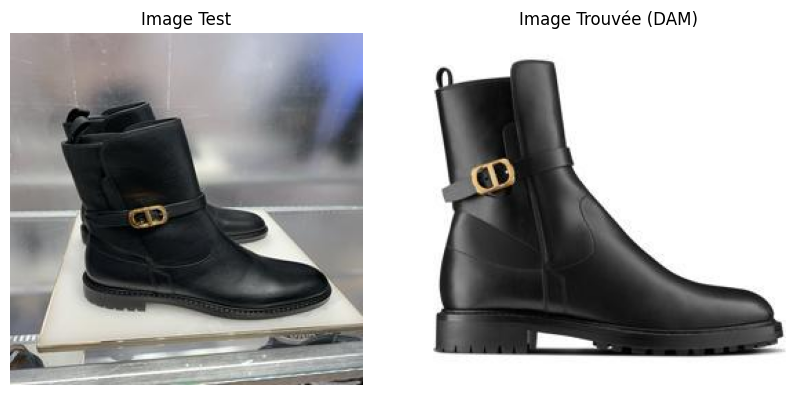

In [52]:


def display_images(test_image_path, dam_image_path):

    test_image = Image.open(test_image_path)
    dam_image = Image.open(dam_image_path)

    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Image Test")
    plt.axis("off")
    plt.subplot(1, 2, 2)
    plt.imshow(dam_image)
    plt.title("Image Trouvée (DAM)")
    plt.axis("off")
    
    plt.show()
# Tester avec une image
test_image_name = list(test_images_resized.keys())[30]
test_embedding = test_embeddings[test_image_name]
closest_image, similarity = find_closest_match(test_embedding, dam_embeddings)

print(f"Image test : {test_image_name}")
print(f"Correspondance trouvée : {closest_image} (Similarité : {similarity:.4f})")
test_dir='test_images_resized'
test_image_path = os.path.join(test_dir, test_image_name)
dam_image_path = os.path.join(dam_dir, closest_image)
display_images(test_image_path, dam_image_path)


In [55]:
def display_and_save_images(test_image_path, dam_image_path, similarity, output_dir, test_image_name, closest_image):
    test_image = Image.open(test_image_path)
    dam_image = Image.open(dam_image_path)
    plt.figure(figsize=(10, 5))
    
    # l'image test
    plt.subplot(1, 2, 1)
    plt.imshow(test_image)
    plt.title("Image Test")
    plt.axis("off")
    
    # l'image DAM correspondante
    plt.subplot(1, 2, 2)
    plt.imshow(dam_image)
    plt.title(f"Image Trouvée (DAM)\nSimilarité : {similarity:.4f}")
    plt.axis("off")
    
    output_filename = f"comparison_{test_image_name}_{closest_image}.png"
    output_path = os.path.join(output_dir, output_filename)
    os.makedirs(output_dir, exist_ok=True)
    plt.savefig(output_path, bbox_inches='tight')
    plt.close() 

    print(f"Image enregistrée sous : {output_path}")


output_dir = "résultat_efficientNet" 

for test_image_name in test_images.keys():
 
    test_embedding = test_embeddings[test_image_name]
    closest_image, similarity = find_closest_match(test_embedding, dam_embeddings)
    print(f"Image test : {test_image_name}")
    print(f"Correspondance trouvée : {closest_image} (Similarité : {similarity:.4f})")
    test_image_path = os.path.join(test_dir, test_image_name)
    dam_image_path = os.path.join(dam_dir, closest_image)
    display_and_save_images(test_image_path, dam_image_path, similarity, output_dir, test_image_name, closest_image)


Image test : IMG_6883.jpg
Correspondance trouvée : M8000VWCMM911.jpeg (Similarité : 0.4382)
Image enregistrée sous : résultat_efficientNet/comparison_IMG_6883.jpg_M8000VWCMM911.jpeg.png
Image test : IMG_6908.jpg
Correspondance trouvée : M9242UNGKM70H.jpeg (Similarité : 0.3947)
Image enregistrée sous : résultat_efficientNet/comparison_IMG_6908.jpg_M9242UNGKM70H.jpeg.png
Image test : IMG_6934.jpg
Correspondance trouvée : KCK325VEAS19O.jpeg (Similarité : 0.4809)
Image enregistrée sous : résultat_efficientNet/comparison_IMG_6934.jpg_KCK325VEAS19O.jpeg.png
Image test : image-20210928-102721-8eaea48f.jpg
Correspondance trouvée : M0538OCALM22Y.jpeg (Similarité : 0.7044)
Image enregistrée sous : résultat_efficientNet/comparison_image-20210928-102721-8eaea48f.jpg_M0538OCALM22Y.jpeg.png
Image test : IMG_6921.jpg
Correspondance trouvée : M0584CVVWM85B.jpeg (Similarité : 0.6774)
Image enregistrée sous : résultat_efficientNet/comparison_IMG_6921.jpg_M0584CVVWM85B.jpeg.png
Image test : IMG_6909.jpg
